**Prediction for Diabetes in Adult Females of Pima Indian Heritage**


**Introduction:**

In the medical industry, the ability to efficiently and effectively detect and remedy diseases is crucial to improving a patient’s health. Quite notably, the early detection of diabetes, a chronic metabolic disorder affecting millions worldwide, can prevent serious complications. Luckily, with advancements in data science we can create models to help predict whether a person has diabetes or not by employing the methods of classification. 

Specifically, we hope to answer the following question: Can we employ the glucose and BMI(Body Mass Index) measurements available to us to predict whether an adult female of Pima Indian heritage has diabetes?

Using an existing data set from The National Institute of Diabetes and Digestive and Kidney Diseases, we will create a classification model to determine the answer to our question. All patients listed in this database are females over the age of 21 and of Pima Indian heritage. This dataset consists of several medical predictors (independent) variables and one target (dependent) variable, Outcome. They have modeled the outcome on two class variables 0 (does not have diabetes) and 1 (has diabetes).


**Preliminary exploratory data analysis:**

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(corrplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in library(corrplot): there is no package called ‘corrplot’


In [28]:
diabetes <- read_csv("https://raw.githubusercontent.com/asnbl/dsci-100-2023-24W-group-16/main/diabetes.csv") 
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [54]:
diabetes_clean <- diabetes |>
    select(Glucose,Outcome,BMI) |>
    mutate(Outcome = as_factor(Outcome)) |>
    rename("Diagnosis" = Outcome)

head(diabetes_clean)

Glucose,Diagnosis,BMI
<dbl>,<fct>,<dbl>
148,1,33.6
85,0,26.6
183,1,23.3
89,0,28.1
137,1,43.1
116,0,25.6


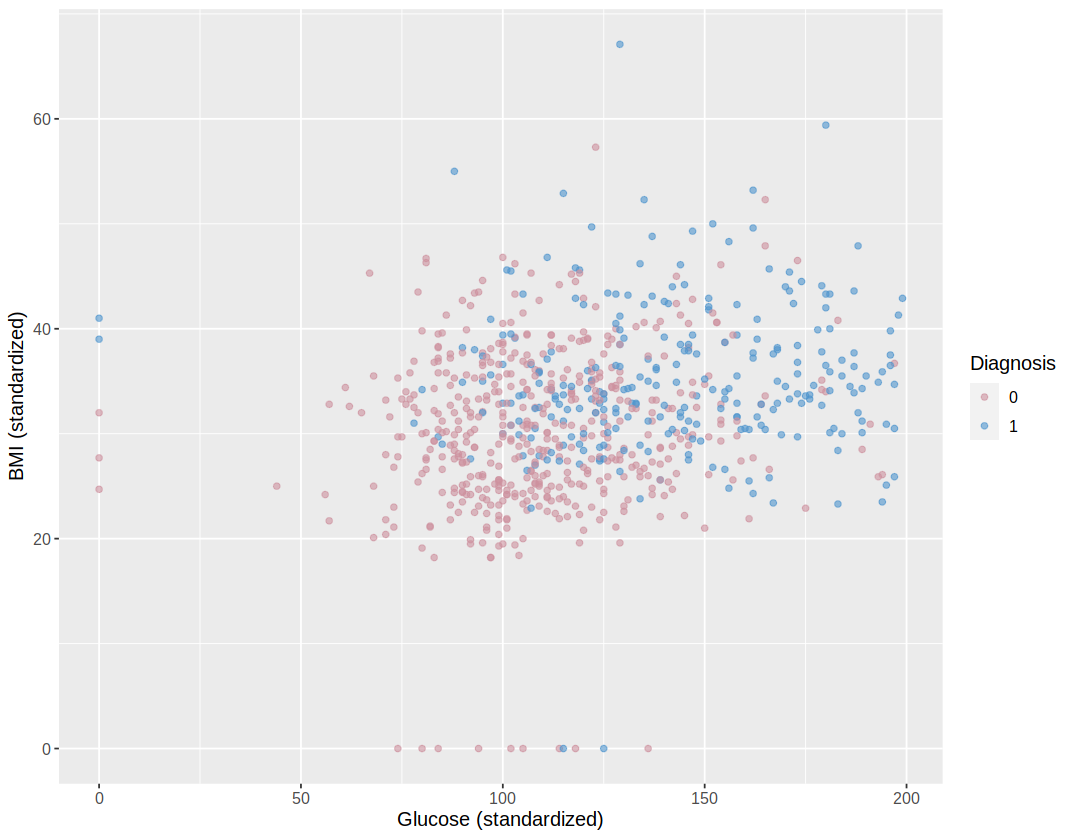

In [55]:
options(repr.plot.width = 9, repr.plot.height = 7)

diabetes_plot <- diabetes_clean |>
   ggplot(aes(x = Glucose, y = BMI, color = Diagnosis)) +
   geom_point(alpha = 0.6) +
   labs(x = "Glucose (standardized)",
        y = "BMI (standardized)",
        color = "Diagnosis") +
scale_color_manual(values = c("pink3","steelblue3")) +
theme(text = element_text(size = 12))
diabetes_plot

**Methods:**

1.First, the foundation for building a good classification prediction model is to load the correct libraries.

2.As our data set is a .csv file, we can then read the data using the read_csv() function.

3.Next, we plan to clean and wrangle the data to make our visualization easily understandable. Not all 9 of the columns in our data set are useful for our prediction. Using the select() function, we will only choose our predictors: Glucose and BMI(Body Mass Index) and also the class we are trying to identify, Diagnosis. The other columns are irrelevant to our question.

4.Then we will determine the k values to compute the straight-line distance between points on a graph when there are two or more predictor variables.  We will use a recipe to preprocess data to be centered, scaled, and balanced.

5.We split the data into training and testing sets. Once the model is trained, it can be used to make predictions on new data using the predict() function.

6.Then we would combine preprocessing and model training using a workflow.

7.Finally, we can create a visualization of the cleaned data using a scatter plot.

**Expected outcomes and significance:**

From our model, we expect to find whether or not a woman of Pima Indian ancestry has diabetes. We will do that by taking a point on the plot and with the help of our predictors (glucose levels and BMI) make our prediction. We anticipate discovering whether these specific characteristics are positively or negatively associated with the occurrence of diabetes, we aim to create a precise classification model to predict if a Pima Indian woman has diabetes.

A model like this will not only contribute to the growing field of predictive medicine but also enhance the concept of preventive healthcare practices which can help improve the  lives of millions who are susceptible to diabetes and timely intervention and adjustments to their lifestyle can aid in managing the condition and lowering the disease's risk.

After the model identifies individuals at high risk, we can then examine the efficiency of various intervention approaches, such as dietary and exercise programs, to determine which ones are the most effective in preventing diabetes.